In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [2]:
# Stemming and all

In [3]:
data = [line.strip() for line in open('reddit_ques.txt', 'r')]

In [4]:
data[:20]

['What are life’s toughest mini games?',
 'What are some slang terms a 50 year old dad can say to his daughter to embarrass her?',
 'Redditors who were in attendance at a wedding that was called off mid-ceremony, what was the story?',
 'What are your best “first date tips” for somebody starting the dating game late in life (late 20’s +)?',
 'Chefs of Reddit, what are the biggest ripoffs that your restaurants sell?',
 'The year is 2050. How do you think you would complete the sentence: "Back in my day, we didn\'t have ..."?',
 'What screams "I\'m emotionally unstable"?',
 'What is an imminent danger that nobody seems to be talking about?',
 'What is the worst purchase you ever made?',
 "What's the WORST name for a strip club you can imagine?",
 'What skills can a poor 19 y/o learn to help make an income and get further in life?',
 'What’s something that you only do because it’s socially standard?',
 'What saying from a movie or television show do you find yourself using in everyday life

In [5]:
questions = data.copy()

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for ques in questions:
    allwords_stemmed = tokenize_and_stem(ques)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(ques)
    totalvocab_tokenized.extend(allwords_tokenized)

In [11]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [12]:
vocab_frame

,words
what,what
are,are
life,life
s,s
toughest,toughest
mini,mini
game,games
what,what
are,are
some,some


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(questions)

print(tfidf_matrix.shape)

Wall time: 315 ms
(457, 4684)


C:\Users\MAYANK\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [17]:
terms = tfidf_vectorizer.get_feature_names()

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [19]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 678 ms


In [23]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [25]:
import pandas as pd

questions_f = {'ques': data, 'cluster': clusters}
frame = pd.DataFrame(questions_f, index=[clusters], columns=['ques', 'cluster'])

In [26]:
frame['cluster'].value_counts()

0    274
1     80
4     50
2     38
3     15
Name: cluster, dtype: int64

In [38]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    print()
    print("Cluster %d questions:" % i, end='')
    for title in frame.ix[i]['ques'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: 's, best, movie, like, why, 've,

Cluster 0 questions: What are some slang terms a 50 year old dad can say to his daughter to embarrass her?, Redditors who were in attendance at a wedding that was called off mid-ceremony, what was the story?, What screams "I'm emotionally unstable"?, What is an imminent danger that nobody seems to be talking about?, What is the worst purchase you ever made?, What's the WORST name for a strip club you can imagine?, What do you regret doing at university?, What song fills you with the most emotions (positive or negative) and why?, What game have you spent the most hours playing?, Which artist has the fakest public image?, [Serious]Redditors with good dads: What solid dad wisdom would you share with the rest of us?, What would you tell an 11 year old girl that is currently experiencing problems with mean girls at school?, [serious] Redditors who have had counselling/therapy, what's the most helpful tip/advice you'v

Cluster 4 questions: The year is 2050. How do you think you would complete the sentence: "Back in my day, we didn't have ..."?, What’s something that you only do because it’s socially standard?, What is something that was normal in your childhood, but now you realize was weird/not okay?, How does an absence of a father affect a child?, People who has interrupted a wedding when asked "If anyone has any reason", How did it go?, If you have an interesting scar, how did you get it?, What is something that everyone on this earth should know?, What’s something you didn’t know you did abnormally/wrong for a long time until one day someone pointed it out to you?, Redditors that have been stalked, how did it start and what happened? (Serious), Who did you believe was the 'one that got away' until you later found out that you dodged a major bullet?, What is something most people have done that you have not?, What is something you find truly fascinating?, What lesson did you learn the hard way?, 

AttributeError: 'KMeans' object has no attribute 'ques_'

In [30]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [32]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [33]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [34]:
%matplotlib inline

C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


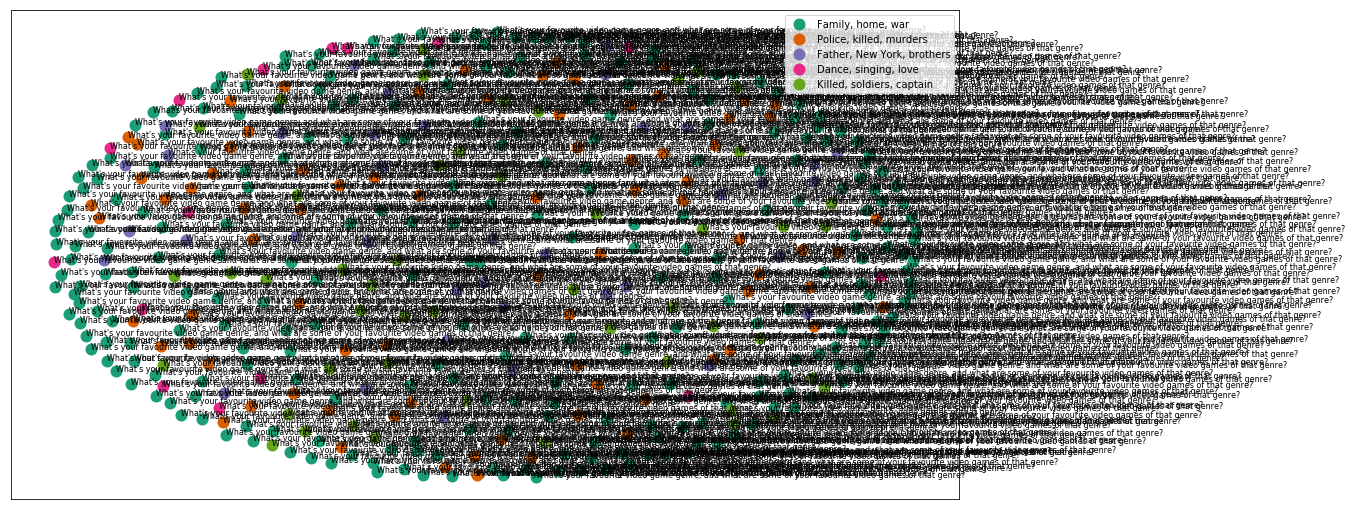

In [39]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys,b label=clusters, title=ques)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [45]:
ques

"What's your favourite video game genre, and what are some of your favourite video games of that genre?"